In [39]:
import gPhoton.gFind as gFind
from gPhoton.gphoton_utils import calculate_jd, calculate_caldat
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
plt.rcParams.update({'font.size': 16})

First let's calculate the flare frequency distribution in two ways, one assuming all the flares come from one of the two stars in the GJ 65 system, the other assuming they are split equally between the two.  These provide upper and lower limits since it's a binary and we don't resolve it so we don't know which flare comes from which star in the system.

In [2]:
# This script will use gFind to calculate the total observation time, ignoring
# the two AIS visits.  Note: this cell can take a few minutes to run 
# while it does the necessary queries.
tot_time_noais = 0
x = gFind(band="NUV", skypos=[24.755006, -17.950739], detsize=1.25)
for tstart, tend in zip(x['NUV']['t0'][:-2], x['NUV']['t1'][:-2]):
        print(str(calculate_jd(tstart)) + ', ' + str(calculate_caldat(tstart)) + " | " + str(calculate_jd(tend)) + ", " + str(calculate_caldat(tend)) + ' -> ' + str((calculate_jd(tend) - calculate_jd(tstart))*24.*60.))
        tot_time_noais = tot_time_noais + (tend-tstart)
print("Total time on source (no AIS): " + str(tot_time_noais / 3600.) + " hours.")
print("Total time on source (no AIS) in seconds: " + str(tot_time_noais) + " seconds.")

NUV: 15900.0s (raw) in 12 exposures.
    [ 816331858.995, 816333466.995 ], 1608.000 seconds
    [ 816337774.995, 816339476.995 ], 1702.000 seconds
    [ 816349606.995, 816351309.995 ], 1703.000 seconds
    [ 816373270.995, 816374974.995 ], 1704.000 seconds
    [ 816379186.995, 816380890.995 ], 1704.000 seconds
    [ 816396934.995, 816398637.995 ], 1703.000 seconds
    [ 816414682.995, 816416179.995 ], 1497.000 seconds
    [ 816426514.995, 816428219.995 ], 1705.000 seconds
    [ 816479758.995, 816481463.995 ], 1705.000 seconds
    [ 844406747.995, 844407398.995 ], 651.000 seconds
    [ 876669575.995, 876669682.995 ], 107.000 seconds
    [ 878130796.995, 878130907.995 ], 111.000 seconds
2453692.7861478915, 2005-11-18 06:50:58.995 | 2453692.8047590023, 2005-11-18 07:17:46.995 -> 26.799999475479126
2453692.8546201135, 2005-11-18 08:29:34.995 | 2453692.874319188, 2005-11-18 08:57:56.995 -> 28.36666703224182
2453692.991564558, 2005-11-18 11:46:46.995 | 2453693.011275206, 2005-11-18 12:15:09.

In [25]:
# Total number of detected flares.  See Section 4.1 in the paper for which flares we include here and why we exclude
# others.  Flares 2 and 12 because we aren't sure the peak is seen in the visit, Flare 8 because it is the only one
# outside our energy bin of 28.5 < log(E) < 29.5, and Flare 10 which is heavily truncated at the start of the visit.
# Thus we are left with 11 flares that with our criteria for FFD calculation.
n_flares = 11
# Total time in minutes spent on source where flares could be detected.
n_minutes = 15682. / 60.
# Use how many sigma when reporting the uncertainties?
sigma = 1

In [26]:
# Calculation assuming all flares come from the same single star in the binary system.
flare_rate_single = n_flares / n_minutes
flare_rate_single_err = np.sqrt(n_flares) / n_minutes
print(f'One star: {flare_rate_single} +/- {sigma*flare_rate_single_err} flares per minute')
rate_single = np.log10(flare_rate_single*60)
rate_err_single = np.log10((flare_rate_single + sigma*flare_rate_single_err)*60) - np.log10(flare_rate_single*60)
print(f'log10(#/hr) = {rate_single} +/- {rate_err_single}')

One star: 0.04208646856268333 +/- 0.01268954772486443 flares per minute
log10(#/hr) = 0.4022937364052934 +/- 0.11444795797429763


In [27]:
# Calculation assuming flares are distributed equally between the two stars in the binary system.
flare_rate_split = n_flares / 2 / n_minutes
flare_rate_split_err = np.sqrt(n_flares / 2) / n_minutes
print(f'Two stars: {flare_rate_split} +/- {sigma*flare_rate_split_err} flares per minute')
rate_split = np.log10(flare_rate_split*60)
rate_err_split = np.log10((flare_rate_split + sigma*flare_rate_split_err)*60) - np.log10(flare_rate_split*60)
print(f'log10(#/hr) = {rate_split} +/- {rate_err_split}')

Two stars: 0.021043234281341666 +/- 0.008972865246441964 flares per minute
log10(#/hr) = 0.1012637407413122 +/- 0.15424176638313172


Now let's compare this FFD with extrapolations from some other sources.  As shown in the first notebook in the repository, the (very approximate!) bolometric corrections from the NUV, Johnson U band, Kepler, and TESS bandpasses are all similar to within a factor of two, thus we do not attempt to correct the FFD energy bins between these filters, since they are all tracking comparable fractions of the total energy for a flare, and none would result in major shifts in bins by changing energies by an order of magnitude.

In [54]:
# Flare rate from Hilton et al. 2011 for "M3-M5 Active" sample. Energies are in log(E) in Johnson U-band.
hilton_alpha = -0.53
hilton_alpha_err = 0.04
hilton_beta = 15.70
hilton_beta_err = 1.2
hilton_emin = 29.41
hilton_emax = 33.58
# Generate array of x and y values based on the range of energies we are looking at.
hilton_xvals = np.linspace(28., 34., 50)
hilton_yvals = [hilton_beta + hilton_alpha*x for x in hilton_xvals]

In [55]:
# Individual FFD from Davenport et al. 2016. There is only one star with
# an estimated isochrone mass near an M5: KIC 5683912 = V541 Lyr.
davenport_alpha = -0.83
davenport_beta = 22.84
# Generate array of x and y values based on the range of energies we are looking at.
davenport_xvals = np.linspace(28., 34., 50)
davenport_yvals = [davenport_beta + davenport_alpha*x for x in davenport_xvals]

In [56]:
# FFD rates from Guenther et al. 2020 using TESS for mid-M dwarfs.
guenther_file = "catalog_per_star_final.csv"
if not os.path.isfile(guenther_file):
    raise IOError("Missing FFD reference file: " + guenther_file + " from repository.")
(tic_id,_,_,_,_,_,_,_,_,_,_,_,_,teff,radius,logg,_,_,_,_,FFD_alpha,FFD_beta,_,_,_,_) = np.genfromtxt(
    guenther_file,unpack=True,dtype=float,comments='#',delimiter=',')
# We only want to plot the FFDs from their sample for stars roughly similar to M5, so let's
# use some approximate ranges for M3-M6 or so.
teff_min = 2500.
teff_max = 3250.
# We'll loop through and plot these later in the cell that makes the figure.

In [57]:
# FFD rates from Howard et al. 2019 from Evryscope.
howard_alpha = -0.97
howard_beta = 30.45
# Generate array of x and y values based on the range of energies we are looking at.
howard_xvals = np.linspace(28., 34., 50)
howard_yvals = [howard_beta + howard_alpha*x for x in howard_xvals]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


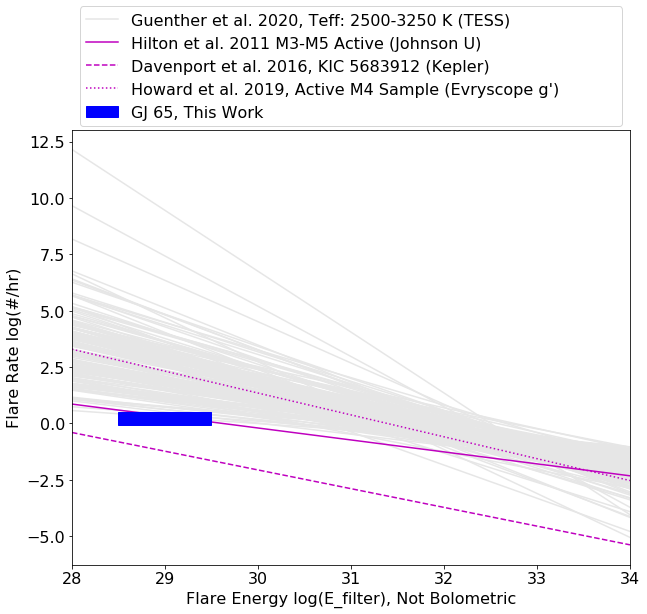

In [78]:
# Plot FFD for each group's results.
fig, ax = plt.subplots(1,figsize=(10,8))

# Plot the M3-M6 dwarf sample from Guenther et al.
guenther_xvals = np.linspace(28., 34., 50)
# This will make it so we only apply a label legend for this sample once.
first_guenther = False
for t,r,a,b in zip(teff,radius,FFD_alpha,FFD_beta):
    if t >= teff_min and t <= teff_max:
        these_guenther_yvals = [b + a*x for x in guenther_xvals]
        if not first_guenther:
            ax.plot(guenther_xvals, these_guenther_yvals, color='0.9',
                    label="Guenther et al. 2020, Teff: {0:4.0f}-{1:4.0f} K (TESS)".format(
                        teff_min, teff_max), zorder=1)
            first_guenther = True
        else:
            ax.plot(guenther_xvals, these_guenther_yvals, color='0.9', zorder=1)

# Plot Hilton et al. FFD relation.
ax.plot(hilton_xvals, hilton_yvals, color='m',
        label="Hilton et al. 2011 M3-M5 Active (Johnson U)", zorder=2)
# Plot Davenport et al. FFD based on KIC 5683912.
ax.plot(davenport_xvals, davenport_yvals, color='m', linestyle='dashed',
        label="Davenport et al. 2016, KIC 5683912 (Kepler)", zorder=2)
# Plot Howard et al. FFD based on 'active M4' group.
ax.plot(howard_xvals, howard_yvals, color='m', linestyle='dotted',
        label="Howard et al. 2019, Active M4 Sample (Evryscope g')", zorder=2)

# Plot our estimated value between 28.5-29.5 log(E).
rect = Rectangle((28.5,rate_split-rate_err_split), 1.0,
                 rate_single+rate_err_single - (rate_split-rate_err_split),
                label="GJ 65, This Work", color='b', zorder=3)
ax.add_patch(rect)
#ax.errorbar(29., rate_single, xerr=0.5, yerr=rate_err_single, color='b', label="This Work, Upper Bound")
#ax.errorbar(29., rate_split, xerr=0.5, yerr=rate_err_split, color='b', label="This Work, Lower Bound")

# Refine plot ranges.
ax.set_xlim([28., 34.])
ax.set_xlabel("Flare Energy log(E_filter), Not Bolometric")
ax.set_ylabel("Flare Rate log(#/hr)")
lgd = ax.legend(loc="upper center", bbox_to_anchor=(0.0,1.2,1.0,0.102), ncol=1, mode="expand")
fig.savefig("figures/ffd.eps", dpi=600,
                bbox_extra_artists=(lgd,), bbox_inches='tight')